# DATA 620 - Assignment 6

Jeremy OBrien, Mael Illien, Vanita Thompson

## Document Classification

* It can be useful to be able to classify new "test" documents using already classified "training" documents. A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam. Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set (http://archive.ics.uci.edu/ml/datasets/Spambase)
* For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).
* For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.


Resources:

- http://www.cs.ucf.edu/courses/cap5636/fall2011/nltk.pdf
- https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html
- https://www.cs.bgu.ac.il/~elhadad/nlp16/spam_classifier.html

Resource: (can be removed)
- https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## Setup

In this assignment, we will look at document classification in the realm of emails with the binary labels 'spam' and 'non-spam', also referred to as 'ham'. The [spamassassin corpus](https://spamassassin.apache.org/old/publiccorpus/) contains individual raw email files which will extracted and processed to form a unified corpus. From this corpus, the data will be split into training and test sets and a variety of models will be developed to identify the best approach to spam email classification. 

The procedure is as follows:
   - Extract emails from raw files
   - Process email content to containly only the body of the emails and ignoring all the headers
   - Apply NLP methods from NLTK and Sklearn to tokenize the email content into features
   - Develop models
   - Compare performance

In [1]:
import re
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

from nltk import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

## Data Import & Transformation

The ham and spam emails are stored in individual files. The `get_emails` function below extracts the content from file and returns a list. 

In [2]:
# Read individual files from current directory and return the content in a list
def get_emails(path):
    emails = []
    files = [path + f for f in listdir(path) if f != 'cmds']

    for file in files:
        with open(file, encoding="latin-1") as f:
            email = f.read()
            if len(email) != 0:
                emails.append(email) 
    return emails

Notice that the ham and spam corpora are not balanced. We will sample the ham corpus to even out the sizes in the training set.

In [3]:
easy_ham = get_emails('./easy_ham/')
spam = get_emails('./spam/')

print('Number of emails in {} corpus: {}'.format('easy_ham', len(easy_ham)))
print('Number of emails in {} corpus: {}'.format('spam', len(spam)))

Number of emails in easy_ham corpus: 2500
Number of emails in spam corpus: 500


Here is an example of the email format. There are a number of headers followed by the body of the email. Our analysis will be focused on the body content. The function `get_email_body` will be used to extract this content. While it is possible that the ignored headers contain useful data for classification, this will be left for further investigation.

In [4]:
print(easy_ham[2001])

From rssfeeds@jmason.org  Mon Oct  7 12:05:27 2002
Return-Path: <rssfeeds@spamassassin.taint.org>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id 4123D16F7C
	for <jm@localhost>; Mon,  7 Oct 2002 12:04:04 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Mon, 07 Oct 2002 12:04:04 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g9780fK23260 for
    <jm@jmason.org>; Mon, 7 Oct 2002 09:00:41 +0100
Message-Id: <200210070800.g9780fK23260@dogma.slashnull.org>
To: yyyy@spamassassin.taint.org
From: gamasutra <rssfeeds@spamassassin.taint.org>
Subject: Postmortem: Ubi Soft China's Music Up -- Summer Rainbow
Date: Mon, 07 Oct 2002 08:00:41 -0000
Content-Type: text/plain; encoding=utf-8

URL: http://www.newsisfree.com/click/-0,8613667,159/
Date: 2002-10-06T18

In [5]:
# Extract only the body of the emails, ignoring all the headers
def get_email_body(email):
    # Looking for the last occurence of Date: Sat, 02 Feb 2002 11:20:17 +1300\n
    iter = re.finditer(r"Date: .*\n", email)
    # Otherwise look for repeated \n\n patterm

    indices = [m.span() for m in iter]
    body_start = indices[-1][1]
    body = email[body_start:].replace("\n", "")

    return body

In [6]:
print(get_email_body(easy_ham[2001]))

Ubi China had always wanted to make a PC game for the local market, but a number to factors kept the idea on hold. In January 2001, the right incentive to motivate Ubi China to try a local project finally arrived: the license for "Music Up", a popular animated property.


The `get_email_body` function is applied to the emails and the corpus is assembled by combining the spam emails with 500 emails sampled from the ham emails to balance the dataset. Known labels ham: 0, spam:1 are also assigned.

In [7]:
# Assemble the corpus by combining the spam emails with 500 emails sampled from the 
# ham emails to balance the dataset and assign the known labels ham: 0, spam:1
random.seed(620)
labeled_emails = ([(get_email_body(em), '0') for em in random.choices(easy_ham, k=500)] + 
                    [(get_email_body(em), '1') for em in spam])

print('There are {} emails in this corpus.'.format(len(labeled_emails)))

There are 1000 emails in this corpus.


## Data Processing

There are a number of NLP methods to process text including tokenizing, case normalization, stopword removal, stemming and lemmatization.

The manual pre-processing section below highlights some of the functionality described above on a sample email. These steps will be encapsulated in the function `process_email_body` with parameters allowing for more control over the processing.



### Manual pre-processing

In [8]:
get_email_body(easy_ham[0])

"In a message dated 9/24/2002 11:24:58 AM, jamesr@best.com writes:>This situation wouldn't have happened in the first place if California>didn't have economically insane regulations.  They created a regulatory>climate that facilitated this.  So yes, it is the product of>over-regulation.>Which is to say, if you reduce the argument to absurdity, that law causes crime. (Yes, I agree that badly written law can make life so frustrating that people have little choice but to subvery it if they want to get anything done. This is also true of corporate policies, and all other attempts to regulate conduct by rules. Rules just don't work well when situations are fluid or ambiguous. But I don't think that the misbehavior of energy companies in California can properly be called well-intentioned lawbreaking by parties who were trying to do the right thing but could do so only by falling afoul of some technicality.)If you want to get to root causes, we should probably go to the slaying of Abel by Cai

In [9]:
# Tokenize
tokens = word_tokenize(get_email_body(easy_ham[0]))
print(tokens[:10])

['In', 'a', 'message', 'dated', '9/24/2002', '11:24:58', 'AM', ',', 'jamesr', '@']


In [10]:
# Normalize
word_tokens = [w.lower() for w in tokens if w.isalpha()] 
print(len(word_tokens))
print(word_tokens[:10])

223
['in', 'a', 'message', 'dated', 'am', 'jamesr', 'writes', 'this', 'situation', 'would']


In [11]:
# Stopword removal 
stop_words = stopwords.words('english')
filtered_words = [w for w in word_tokens if not w in stop_words]
print(len(filtered_words))
print(filtered_words[:10])

107
['message', 'dated', 'jamesr', 'writes', 'situation', 'would', 'happened', 'first', 'place', 'california']


In [12]:
# Stemming
porter = PorterStemmer()
stemmed_words = [porter.stem(t) for t in filtered_words]
print(stemmed_words[:20])

['messag', 'date', 'jamesr', 'write', 'situat', 'would', 'happen', 'first', 'place', 'california', 'econom', 'insan', 'regul', 'creat', 'regulatori', 'climat', 'facilit', 'ye', 'product', 'say']


### Manual pre-processing (encapsulated):

As described above, the function `process_email_body` can be applied to each email in order to turn the content of the emails into useable features.

In [13]:
# Process email: tokenize, remove non-alpha characters, remove stop words, stem, lemmatize
# and return a list of tokens
def process_email_body(email, alpha=True, rm_stopwords=True, stem=True, lemma=False):
    tokens = word_tokenize(email)
    if alpha: tokens = [w.lower() for w in tokens if w.isalpha()] 
    if rm_stopwords: 
        stop_words = stopwords.words('english')
        tokens = [w for w in tokens if not w in stop_words]
    if stem:
        porter = PorterStemmer()
        tokens = [porter.stem(t) for t in tokens]
    return tokens

In [14]:
# Example above revisited using the function
print(process_email_body(get_email_body(easy_ham[0])))

['messag', 'date', 'jamesr', 'write', 'situat', 'would', 'happen', 'first', 'place', 'california', 'econom', 'insan', 'regul', 'creat', 'regulatori', 'climat', 'facilit', 'ye', 'product', 'say', 'reduc', 'argument', 'absurd', 'law', 'caus', 'crime', 'ye', 'agre', 'badli', 'written', 'law', 'make', 'life', 'frustrat', 'peopl', 'littl', 'choic', 'subveri', 'want', 'get', 'anyth', 'done', 'also', 'true', 'corpor', 'polici', 'attempt', 'regul', 'conduct', 'rule', 'rule', 'work', 'well', 'situat', 'fluid', 'ambigu', 'think', 'misbehavior', 'energi', 'compani', 'california', 'properli', 'call', 'lawbreak', 'parti', 'tri', 'right', 'thing', 'could', 'fall', 'afoul', 'technic', 'want', 'get', 'root', 'caus', 'probabl', 'go', 'slay', 'abel', 'cain', 'perhap', 'figur', 'went', 'wrong', 'roll', 'learn', 'forward', 'histori', 'creat', 'say', 'cast', 'stone', 'hous', 'whether', 'bicamer', 'unicamer', 'built', 'sand', 'rock', 'left', 'right', 'glass', 'brick', 'twig', 'straw', 'tom']


#### Consider additional feature engineering?

MI: incorporate this into text if needed

- number of tokens, etc.
- presence of word 'unsubscribe'

For feature engineering, what would you say to the following combinations:

- yes case normalization, yes symbol removal, yes stopword removal, then stem
- yes case normalization, yes symbol removal, no stopword removal, then stem
- yes case normalization, no symbol removal, no stopword removal, then stem
- no case normalization, no symbol removal, no stopword removal, then stem
  
  
- yes case normalization, yes symbol removal, yes stopword removal, then lemmatize
- yes case normalization, yes symbol removal, no stopword removal, then lemmatize
- yes case normalization, no symbol removal, no stopword removal, then lemmatize
- no case normalization, no symbol removal, no stopword removal, then lemmatize
  
  
- yes case normalization, yes symbol removal, yes stopword removal, no stem / lemmatize
- yes case normalization, yes symbol removal, no stopword removal, no stem / lemmatize
- yes case normalization, no symbol removal, no stopword removal, no stem / lemmatize
- no case normalization, no symbol removal, no stopword removal, no stem / lemmatize
  
Then once we've determine the best performer, we can implement some sort of error correction to see if that improves it.

Then we can try versions of the best performer that are noun-only or verb-only (with the settings above, so long as not contradictory)


Unfortunately, run time becomes excessive when emails processed with the manual approach are vectorized and the transformation applied to the emails using the code block below. For this reason, we will rely on the efficiency of the built-in pre-processor of the sklearn library for the remainder of the assignment.

In [15]:
# Option 1: manual pre-processing (takes a long time to run)

# emails = [process_email_body(email) for email in labeled_emails] # X
# y = [label for (email, label) in labeled_emails] # y = labels

# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(emails) # run time takes too long.

### Processing using sklearn

The sklearn `TfidfVectorizer` object allows us to apply the same processing steps that we manually outlined below via the function paramters.

In [16]:
# Option 2
# Refer to https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

emails = [email for (email, label) in labeled_emails] # X = emails features (see below)
y = [label for (email, label) in labeled_emails] # y = labels

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', token_pattern = r'[a-zA-Z]+', max_features=1000)

X = vectorizer.fit_transform(emails)

Taking a look as some of the features returned by the vectorizer, we find english words such as 'address' or 'advertising' but also a number of html tags such as 'cellpadding' or 'bgcolor' which are often typical of spam emails.

In [17]:
print(vectorizer.get_feature_names()[:200])

['aa', 'ab', 'able', 'absolutely', 'ac', 'accept', 'access', 'account', 'act', 'action', 'actually', 'ad', 'adclick', 'add', 'additional', 'address', 'addresses', 'admanmail', 'admin', 'ads', 'adult', 'advertising', 'ae', 'af', 'ag', 'age', 'agent', 'agents', 'ago', 'ahref', 'aid', 'al', 'align', 'allow', 'alsa', 'alt', 'alternative', 'america', 'american', 'amp', 'annuity', 'answer', 'application', 'apply', 'archive', 'area', 'arial', 'article', 'ascii', 'asciicontent', 'ask', 'asp', 'assist', 'assistance', 'atoll', 'au', 'aug', 'available', 'average', 'aw', 'away', 'awr', 'b', 'ba', 'background', 'bad', 'bank', 'banners', 'base', 'based', 'bb', 'bc', 'beenthere', 'begin', 'believe', 'benefit', 'best', 'better', 'bgcolor', 'bidi', 'big', 'bin', 'bindex', 'bit', 'bitx', 'black', 'blank', 'blockquote', 'blue', 'body', 'bonus', 'book', 'border', 'bordercolor', 'boundary', 'box', 'br', 'build', 'bulk', 'bulklist', 'bush', 'business', 'businesses', 'buy', 'c', 'ca', 'called', 'came', 'camp

In [18]:
print(X.shape)

(1000, 1000)


## Modeling

In this section, a number of models are examined including two Naive Bayes approaches (Gaussian & Bernoulli), Decision Trees, SVM, Adaptive Boosting and Random Forests.

The dataset is split into test and training sets and evualted using a number of models in the section that follows.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

The function below will be used to display summaries of each model. It also returns the model and accuracy measures for further use in a summary dataframe. 

Given for a spam detection use case:
- the cost of false positives are high (i.e. misclassifying a legitimate email as spam would mean a use loses a valid communication which could be very important);
- the cost of false negatives are low (i.e. the inconvenience of junk emails or risk of unwittingly clicking on malicious links;
- and, therefore, there's little need to balance between two;

Precision is a better metric to focus on for the assignment.

In [20]:
models = [] # holds model and accuracy information

def build_and_score_model(model, model_name, X_train, y_train, X_test, y_test):
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Training set accuracy
    train_acc = model.score(X_train,y_train)
    print('Model training set accuracy: {} \n'.format(train_acc))
    
    # Testing set accuracy
    test_acc = model.score(X_test, y_test)
    print('Model test set accuracy: {} \n'.format(test_acc))
    
    # Precision
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data = cm, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Actual Ham', 'Actual Spam'])
    print(cm)
    print('\n')
          
    print(classification_report(y_test, y_pred, target_names=['ham','spam']))
    
    models.append([model_name, model, test_acc, precision])

### Naive Bayes - Gaussian

In this model, the likelihood of the features is assumed to be Gaussian and is typically better suited for continuous data.

In [21]:
# Required because of complaint about the matrix being too sparse
X_train = X_train.toarray()
X_test = X_test.toarray()

In [22]:
# Instantiate and train Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

The precision of the Gaussian Naive Bayes classifier is 0.92, and it misidentifies 10 spam emails as ham and 12 ham emails as spam.

In [23]:
build_and_score_model(gnb, 'NaiveBayesGaussian', X_train, y_train, X_test, y_test)

Model training set accuracy: 0.98 

Model test set accuracy: 0.9266666666666666 

             Predicted Ham  Predicted Spam
Actual Ham             134              12
Actual Spam             10             144


              precision    recall  f1-score   support

         ham       0.93      0.92      0.92       146
        spam       0.92      0.94      0.93       154

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



### Naive Bayes - Bernoulli

This Bernoulli Naive Bayes model assumes that all our features are binary meaning that either the feature does, or does not appear in the document. This kind of model typically performs better on shorted documents, like emails.

In [24]:
# Instantiate and train Gaussian Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

The precision of the Bernoulli Naive Bayes classifier is 0.97, and it misidentifies 25 spam emails as ham and 4 ham emails as spam. While this model allowed for more spam emails to be classified as ham than the above, there were less actual ham emails classified as spam. 

In [25]:
build_and_score_model(bnb, 'NaiveBayesBernoulli', X_train, y_train, X_test, y_test)

Model training set accuracy: 0.9057142857142857 

Model test set accuracy: 0.9033333333333333 

             Predicted Ham  Predicted Spam
Actual Ham             142               4
Actual Spam             25             129


              precision    recall  f1-score   support

         ham       0.85      0.97      0.91       146
        spam       0.97      0.84      0.90       154

    accuracy                           0.90       300
   macro avg       0.91      0.91      0.90       300
weighted avg       0.91      0.90      0.90       300



Of the two Naive Bayes model, the Bernoulli had a slightly lower accuracy but higher precision. For a real email classifier, this is a better result.

### Decision Tree Classifier

In [26]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
    max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=1e-07, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0,
    random_state=88, splitter='best')
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=1e-07, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=88, splitter='best')

The Decision Tree model is an improvement on the Naive Bayes classifiers both in terms of accuracy with a score of 0.96 and in terms of precision which reaches 0.97. Classification errors both for ham and spam emails were also reduced with only 4 ham emails classified as spam and 8 spam classified as ham.

In [27]:
build_and_score_model(dt, 'DecisionTree', X_train, y_train, X_test, y_test)

Model training set accuracy: 1.0 

Model test set accuracy: 0.96 

             Predicted Ham  Predicted Spam
Actual Ham             142               4
Actual Spam              8             146


              precision    recall  f1-score   support

         ham       0.95      0.97      0.96       146
        spam       0.97      0.95      0.96       154

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



### Support Vector Machines

Support Vector Machines is a classifier which makes use of a 'kernel trick' to efficiently transform data to a new space in which the margin between different classes can be maximized using a hyperplane.

We employ two common kernels - **linear** and **radial basis function (RBF)** - to evaluate their respective performance.

SVM kernels take different parameters depending on the kernel type.  The *C* parameter is a regularization term that penalizes misclassification (i.e. a lower value imposes a softer class boundary, or higher value a harder), and it is used for both linear and RBF kernels.  The RBF kernel also takes a *gamma* parameter, which controls the distance over which a given training example influences the boundary.

We define a function to perform a grid search to identify good candidates for *C* (for linear and RBF) and gamma (for RBF only) parameters.  Due to computational load, we limit the cross validation to five folds (optimally this would be 10.)

In [28]:
# Configure grid search for hyperparameter tuning at exponential increments
def svm_tune_grid(X, y, kernel, nfolds):
    
    C = [.0001,.001,.01,.1,1,10]
    gamma = [.0001,.001,.01,.1,1,10]
    
    # For linear kernels
    if kernel == 'linear':
        param_grid = {'C': C}
        grid_search = GridSearchCV(svm.SVC(kernel=kernel), 
                                   param_grid, 
                                   cv=nfolds)
    
    # For RBF kernels
    elif kernel == 'rbf':
        param_grid = {'C': C, 'gamma': gamma}
        grid_search = GridSearchCV(svm.SVC(kernel=kernel), 
                                   param_grid, 
                                   cv=nfolds)
    
    # Other kernels are not supported by this function
    else:
        print('Kernel not recognized or supported')
        return
    
    grid_search.fit(X,y)
    grid_search.best_params_
    
    return grid_search.best_params_

In [29]:
# Grid search for optimal C and gamma in linear kernel
svm_tune_grid(X_train, y_train, 'linear', 5)

{'C': 1}

In [30]:
# Grid search for optimal C and gamma in radial basis function kernel
svm_tune_grid(X_train, y_train, 'rbf', 5)

{'C': 10, 'gamma': 0.1}

As the grid search returned an optimal *C* value of 10 for both kernels, and a *gamma* value of 1 for the RBF kernel, we fit the two versions of the SVM classifier accordingly.

First we fit an SVM classifier with linear kernel.

In [31]:
# Fit SVM classifier with linear kernel on training set
svm_lin = svm.SVC(C=10,  # identified by grid search
               kernel='linear')
svm_lin.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

The precision of the linear kernel SVM classifier is 0.97, and it only misidentifies five spam emails as ham and five ham emails as spam.

In [32]:
build_and_score_model(svm_lin, 'SVMLinearKernel', X_train, y_train, X_test, y_test)

Model training set accuracy: 1.0 

Model test set accuracy: 0.9766666666666667 

             Predicted Ham  Predicted Spam
Actual Ham             144               2
Actual Spam              5             149


              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       146
        spam       0.99      0.97      0.98       154

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



Next we fit an SVM classifier with an RBF kernel.

In [33]:
# Fit SVM classifier with RBF kernel on training set
svm_rbf = svm.SVC(C=10,  # identified by grid search
               kernel='rbf',
                 gamma=1)  # identified by grid search
svm_rbf.fit(X_train,y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

The precision of the RBF kernel SVM classifier is 0.98, and it only misidentifies four spam emails as ham and three ham emails as spam.

In [34]:
build_and_score_model(svm_rbf, 'SVMRBFKernel', X_train, y_train, X_test, y_test)

Model training set accuracy: 1.0 

Model test set accuracy: 0.97 

             Predicted Ham  Predicted Spam
Actual Ham             144               2
Actual Spam              7             147


              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       146
        spam       0.99      0.95      0.97       154

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



Of the two SVM classifiers, the RBF kernel performs incrementally better than the linear kernel.  This means that a non-linear boundary in the hyperplane better distinguishes between the two classes.  As we encountered at runtime, the RBF kernel requires greater computational resources, and its incrementally better performance should be weighed against it's cost.  This is particularly true if a model like this is being deploued into production and scaled.

### Adaptive Boosting

In [35]:
ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=88)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=88)

The Adaptive Boosting model rivals the SVM models on precision and accuracy with only 9 errors: 2 ham emails classified as spam and 7 spam emails classified as ham.

In [36]:
build_and_score_model(ada, 'AdaptiveBoosting', X_train, y_train, X_test, y_test)

Model training set accuracy: 1.0 

Model test set accuracy: 0.97 

             Predicted Ham  Predicted Spam
Actual Ham             144               2
Actual Spam              7             147


              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       146
        spam       0.99      0.95      0.97       154

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



### Random Forest

In [37]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=88,
            verbose=0, warm_start=False)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-07, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

The Random Forest model achieves 0.99 precision which is the highest score so far. Only a single ham email is classified as spam. The accuracy of 0.963 is slightly lower than the SVM models due the the 10 spam emails incorrectly classified as ham. 

In [38]:
build_and_score_model(rf, 'RandomForest', X_train, y_train, X_test, y_test)

Model training set accuracy: 0.9985714285714286 

Model test set accuracy: 0.9633333333333334 

             Predicted Ham  Predicted Spam
Actual Ham             145               1
Actual Spam             10             144


              precision    recall  f1-score   support

         ham       0.94      0.99      0.96       146
        spam       0.99      0.94      0.96       154

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.97      0.96      0.96       300



## Conclusion

The `models` list that stored the models and performance metrics is unfolded to summarize the findings of this investigation in a dataframe.

In [39]:
def summarize_models(models):
    table = pd.DataFrame(columns = ['model', 'acc_test', 'precision'])
    
    for m in models:
        df = pd.DataFrame({'model': [m[0]], 'acc_test': [m[2]], 'precision': [m[3]]})
        table = table.append(df, ignore_index=True)

    return table

In [40]:
table = summarize_models(models)
table.style.background_gradient(cmap='Blues')

,model,acc_test,precision
0,NaiveBayesGaussian,0.926667,0.923077
1,NaiveBayesBernoulli,0.903333,0.969925
2,DecisionTree,0.960000,0.973333
3,SVMLinearKernel,0.976667,0.986755
4,SVMRBFKernel,0.970000,0.986577
5,AdaptiveBoosting,0.970000,0.986577
6,RandomForest,0.963333,0.993103


Here two principal metrics are used to determine how 'good' a model is. SVM based models turned out to be the most accurate. However, as stated earlier, a spam email classifier is more concerned with penalizing misclassifications of ham emails as spam while being more tolerant of the occasional spam email going through to the ham box. The precision metric revealed that the Random Forest model was the most precise with only a single ham email classified as spam.

Both of these models are the best in their own way and they are select below by index. 

Based on the consistenly high scores in both test set accuracy and precision, the SVMLinearKernel delivers the best overall performance.

In [41]:
most_accurate_model = models[3][1] # Select the best model by index from the table above
most_accurate_model

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
most_precise_model = models[6][1] # Select the best model by index from the table above
most_precise_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-07, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

To quickly examine why the Random Forest model was so precise in identifying spam emails correctly, we take a look at the most importance features. We can regognize the majority of these features as HTML tags. This tell us that spam emails are easily identifiable by the amount of HTML present in the body of an email which differentiates them from emails whose bodies are simply plain text.

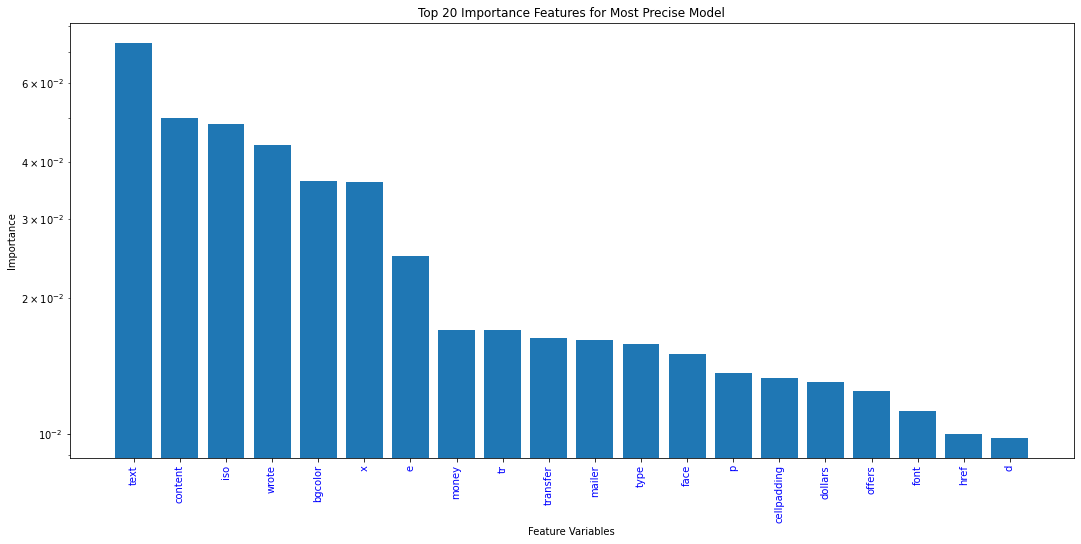

In [43]:
feature_importance = [i for i in zip(vectorizer.get_feature_names(), most_precise_model.feature_importances_)]
feature_importance_20 = sorted(feature_importance, key = lambda x: x[1], reverse=True)[:20]
features = [f for (f, i) in feature_importance_20]
importance = [i for (f, i) in feature_importance_20]
plt.figure(figsize=(18, 8))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(importance)), importance, align='center')
plt.xticks(range(len(importance)), features, rotation='vertical', color = 'blue')
plt.title('Top 20 Importance Features for Most Precise Model')
plt.ylabel('Importance')
plt.xlabel('Feature Variables')
plt.show()

## Youtube